## Plastic Cashback Prediction Model ##

In [3]:
# Step 0 — Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_absolute_error

import joblib

## Step 1 — Load & preview data ##

In [2]:
df = pd.read_csv("plastic_cashback_synthetic.csv", parse_dates=["date"])
df.head()


,date,region,bottle_size_ml,plastic_grade,cashback_bdt,market_recycle_price_bdt_per_kg,user_density_per_km2,awareness_index,distance_to_collection_km,rain_mm,campaign,bottles_sold,return_rate_percent,return_count,gross_recycle_value_bdt,cashback_cost_bdt,net_benefit_bdt
0,2025-01-30,Barishal,500,2,4.42,71.11,15,0.207,0.69,75.1,0,1609,46.34,746,795.72,3297.32,-2501.60
1,2024-10-18,Dhaka,250,3,2.31,57.56,1051,0.597,1.22,94.5,0,319,50.72,162,69.94,374.22,-304.28
2,2024-10-20,Rangpur,1000,3,4.23,75.34,8,0.252,1.29,140.7,0,1152,48.66,561,1267.97,2373.03,-1105.06
3,2023-09-02,Barishal,250,5,5.24,22.14,12,0.172,1.95,153.6,1,3777,65.70,2481,411.97,13000.44,-12588.47
4,2023-06-04,Mymensingh,1000,1,3.01,66.00,17,0.674,0.68,170.8,1,1244,55.18,686,1358.28,2064.86,-706.58


## Step 2 — Quick EDA ##

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 17 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   date                             3000 non-null   datetime64[ns]
 1   region                           3000 non-null   object        
 2   bottle_size_ml                   3000 non-null   int64         
 3   plastic_grade                    3000 non-null   int64         
 4   cashback_bdt                     3000 non-null   float64       
 5   market_recycle_price_bdt_per_kg  3000 non-null   float64       
 6   user_density_per_km2             3000 non-null   int64         
 7   awareness_index                  3000 non-null   float64       
 8   distance_to_collection_km        3000 non-null   float64       
 9   rain_mm                          3000 non-null   float64       
 10  campaign                         3000 non-null   int64      

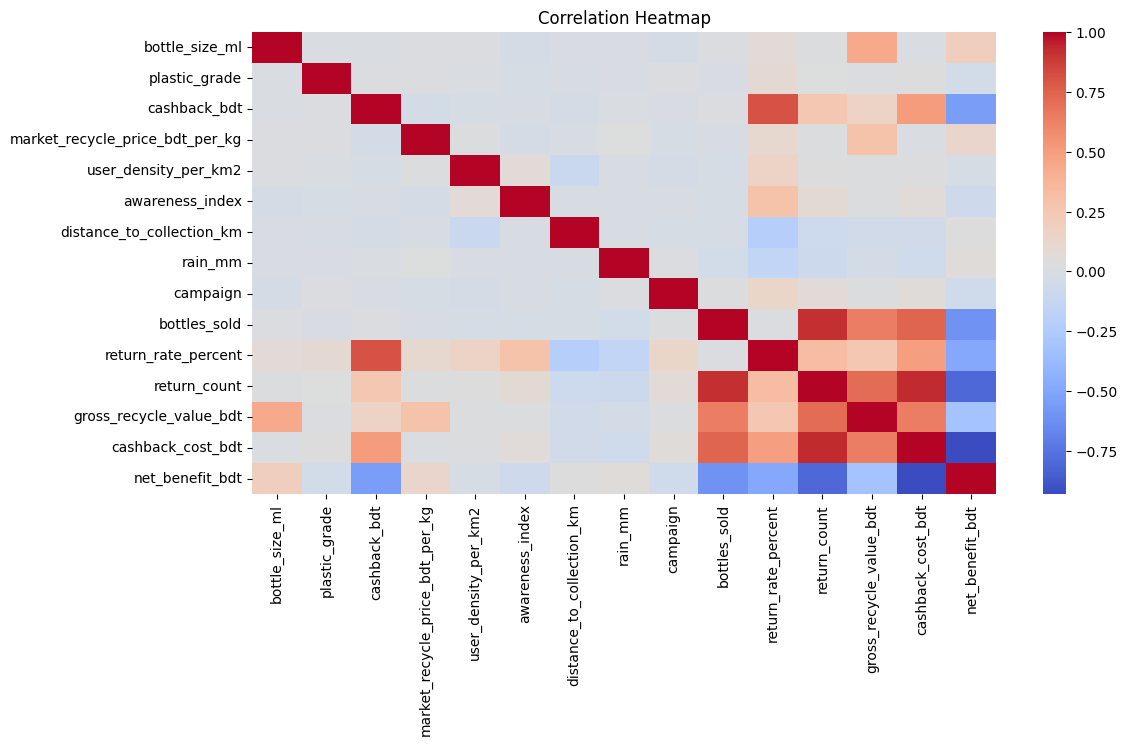

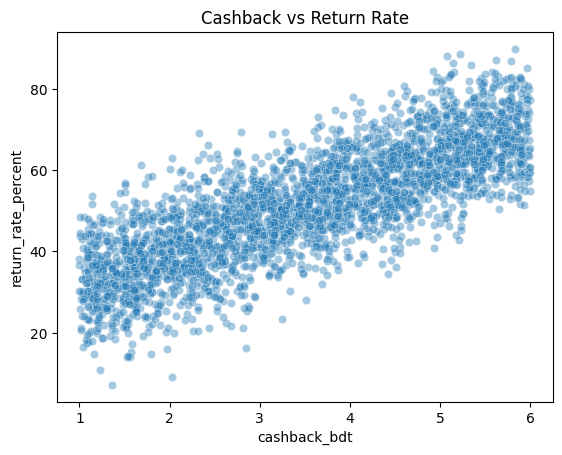

In [4]:
print(df.info())
print(df.describe())

# Correlation heatmap
plt.figure(figsize=(12,6))
sns.heatmap(df.corr(numeric_only=True), annot=False, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

# Cashback vs Return Rate
sns.scatterplot(x="cashback_bdt", y="return_rate_percent", data=df, alpha=0.4)
plt.title("Cashback vs Return Rate")
plt.show()


## Step 3 — Prepare features & target #3

In [5]:
features = [
    "cashback_bdt","bottle_size_ml","plastic_grade",
    "market_recycle_price_bdt_per_kg","user_density_per_km2",
    "awareness_index","distance_to_collection_km","rain_mm",
    "campaign","region"
]
X = df[features]
y = df["return_rate_percent"]

num_feats = [
    "cashback_bdt","bottle_size_ml","plastic_grade",
    "market_recycle_price_bdt_per_kg","user_density_per_km2",
    "awareness_index","distance_to_collection_km","rain_mm","campaign"
]
cat_feats = ["region"]


## Step 4 — Train Linear/Ridge Regression ##

In [6]:
from sklearn.linear_model import Ridge

pre = ColumnTransformer([
    ("num", StandardScaler(), num_feats),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_feats)
])

pipe = Pipeline([
    ("pre", pre),
    ("model", Ridge())
])

param_grid = {"model__alpha": [0.1, 0.5, 1.0, 2.0, 5.0]}
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

gs = GridSearchCV(pipe, param_grid, cv=5, scoring="r2", n_jobs=-1)
gs.fit(X_train, y_train)

print("Best Alpha:", gs.best_params_)
pred = gs.predict(X_test)
print("R²:", r2_score(y_test, pred))
print("MAE:", mean_absolute_error(y_test, pred))


Best Alpha: {'model__alpha': 5.0}
R²: 0.8798588769421797
MAE: 3.8714864681350507


## Step 5 — Interpret coefficients ##

C:\Users\User\AppData\Local\Temp\ipykernel_2176\3269516342.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=coef_df, x="coef", y="feature", palette="coolwarm")


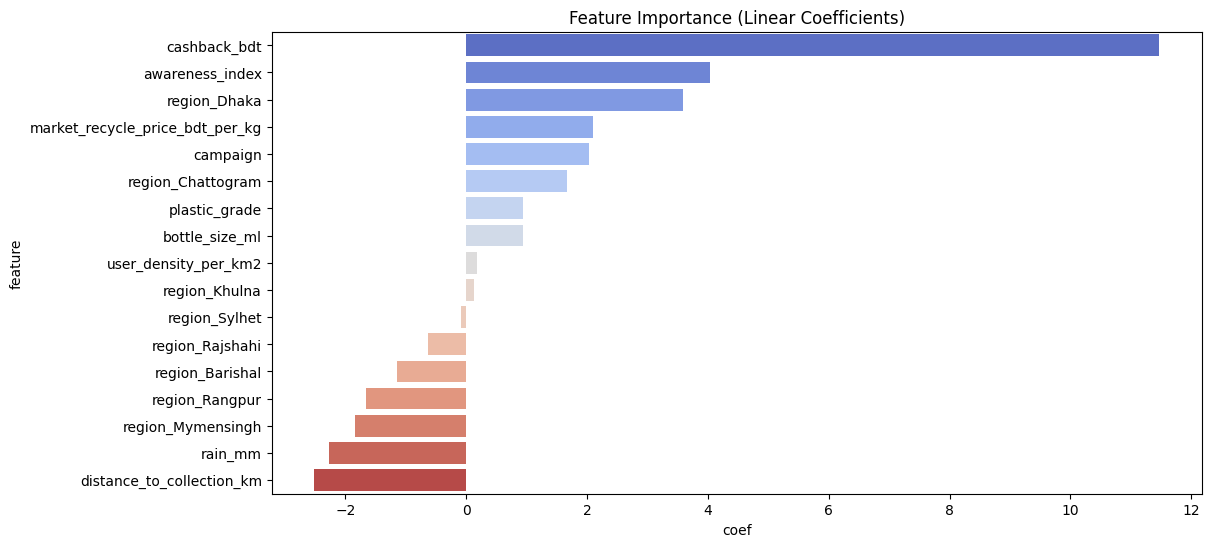

In [7]:
# Retrieve coefficients after preprocessing
best_model = gs.best_estimator_
ohe = best_model.named_steps["pre"].named_transformers_["cat"]
feature_names = num_feats + list(ohe.get_feature_names_out(cat_feats))

coefs = best_model.named_steps["model"].coef_
coef_df = pd.DataFrame({"feature": feature_names, "coef": coefs}).sort_values("coef", ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(data=coef_df, x="coef", y="feature", palette="coolwarm")
plt.title("Feature Importance (Linear Coefficients)")
plt.show()


## Step 6 — Model Done ##

In [8]:
joblib.dump(gs.best_estimator_, "cashback_lr_pipeline.pkl")
print("Model saved as cashback_lr_pipeline.pkl")


Model saved as cashback_lr_pipeline.pkl
